# Week 6 - Logistic Regression

**Student Name 1, Student Name 2**

### Aims

The main concepts covered in this notebook are:

>* logistic regression
>* performance metrics for classification
>* dealing with imbalanced data 
>* multi-class logistic regression

1. [Setup](#setup)

2. [Binary Logistic Regression](#RBH)

3. [Regularization](#SKV)

4. [Imbalanced Data](#Imbal)

5. [Multi-class Example](#mclog)


This week we will be implementing logistic regression for a classification task. 

- We will mainly focus on the data set stored in `Default.csv`.
- For the multi-class example, we consider the `iris data` at the end of the notebook.

During workshops, you will complete the worksheets together in teams of 2-3, using **pair programming**. You should aim to switch roles between driver and navigator approximately every 15 minutes. When completing worksheets:

>- You will have tasks tagged by (CORE) and (EXTRA). 
>- Your primary aim is to complete the (CORE) components during the WS session, afterwards you can try to complete the (EXTRA) tasks for your self-learning process. 
>- In some Exercises, you will see some beneficial hints at the bottom of questions.

Instructions for submitting your workshops can be found at the end of worksheet. As a reminder, you must submit a pdf of your notebook on Learn by 16:00 PM on the Friday of the week the workshop was given.

---

# Setup <a id='setup'></a>

## Packages

Let's load the packages we need for this workshop.

In [11]:
# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
from sklearn.linear_model import LogisticRegression

# Other necessary packages
from sklearn.preprocessing import StandardScaler # scaling features
from sklearn.pipeline import make_pipeline           # combining classifier steps
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold 
from sklearn.model_selection import train_test_split

## Helper Functions

We will make use of one of the helper functions that we saw last week.

In [12]:
def get_coefs(m, plot = False, feature_names = None, figsize = (5,5), figtitle = None, intercept = True):
    """Returns model coefficients in a data frame for a fitted linear model.
    
    Args:
        m: sklearn linear model object or pipeline with linear model as final step
        plot: boolean value, should coefficients be plotted with error bars
        feature_names: list of feature names to use in the plot 
        figsize: tuple defining figure size
        figtitle: string defining figure title
        intercept: boolean value, should intercept be included in the plot
    """
    
    # Extract intercept and coefficients into a single array
    w0 = m[-1].intercept_ if isinstance(m, sklearn.pipeline.Pipeline) else m.intercept_
    w1 = m[-1].coef_ if isinstance(m, sklearn.pipeline.Pipeline) else m.coef_
    w = np.concatenate((w0.reshape(-1), w1.reshape(-1)))
    # Extract name of features
    if feature_names is None:
        feature_names = m[:-1].get_feature_names_out() if isinstance(m, sklearn.pipeline.Pipeline) else m.feature_names_in_
    feature_names = np.concatenate((['intercept'], feature_names))
    # Create a data frame
    w_df = pd.DataFrame({'feature': feature_names, 'coef': w}).sort_values ("coef", ascending=False)

    if plot:
        if not intercept:
            w_df = w_df[w_df['feature'] != 'intercept']
        plt.figure(figsize=figsize)
        plt.barh(w_df['feature'], w_df['coef'])
        plt.ylabel('Features')
        plt.xlabel('Coefficient Value')
        plt.axvline(x=0, color=".5")
        if figtitle is not None:
            plt.title(figtitle)
        plt.grid()
        plt.show()
    
    return  w_df

## Data

The dataset collects information on **10000** individuals, recording whether they defaulted on their credit card or not as well as other characteristics. Specifically, the included columns in the data are:

* `default` - Whether the individual has defaulted

* `student` - Whether the individual is the student

* `balance` - The balance in the individual's account

* `income` - Income of an individual

Our aim is to build a model using Logistic Regression to predict if person will default or not.

In [13]:
df_default = pd.read_csv("Default.csv", index_col=0)

df_default.head()

,default,student,balance,income
1,No,No,729.526495,44361.62507
2,No,Yes,817.180407,12106.13470
3,No,No,1073.549164,31767.13895
4,No,No,529.250605,35704.49394
5,No,No,785.655883,38463.49588


## Exploratory Data Analysis

We will start with explanatory data analysis (EDA) to get more insight about the data. 

### 🚩 Exercise 1 (CORE)

Examine the structure of the data. Consider the following questions:

a. What are the types of each variable? Based on the descriptive statistics, do anticipate any feature engineering steps that may be needed? Are there any missing values in the data? 

b. Visualize the features (balance, income, student) and comment on any differences that you observe between individuals that have defaulted 

In [14]:
# Part a: info and descriptive statistics
# Code for your answer here!
df_default.info()
display(df_default.describe(include='all'))
print(df_default.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 390.6+ KB


,default,student,balance,income
count,10000,10000,10000.000000,10000.000000
unique,2,2,NaN,NaN
top,No,No,NaN,NaN
freq,9667,7056,NaN,NaN
mean,NaN,NaN,835.374886,33516.981876
std,NaN,NaN,483.714985,13336.639563
min,NaN,NaN,0.000000,771.967729
25%,NaN,NaN,481.731105,21340.462905
50%,NaN,NaN,823.636973,34552.644800
75%,NaN,NaN,1166.308387,43807.729275


default    0
student    0
balance    0
income     0
dtype: int64


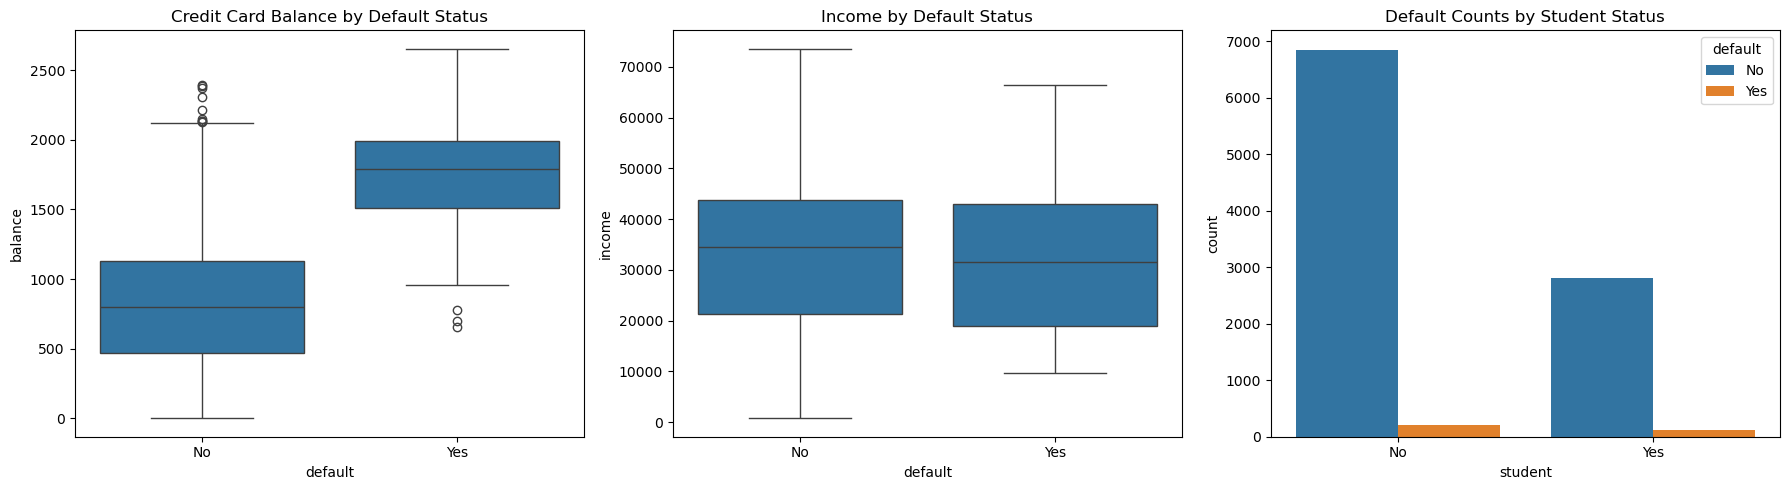

In [15]:
# Part b: Visualize the data
# Code for your answer here!
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(ax=axes[0], data=df_default, x='default', y='balance')
axes[0].set_title('Credit Card Balance by Default Status')

sns.boxplot(ax=axes[1], data=df_default, x='default', y='income')
axes[1].set_title('Income by Default Status')

sns.countplot(ax=axes[2], data=df_default, x='student', hue='default')
axes[2].set_title('Default Counts by Student Status')

plt.tight_layout()
plt.show()

_a) Variable Types: default and student are categorical variables (type object), while balance and income are continuous numerical variables (type float64). Feature Engineering: Looking at the descriptive statistics, income is on a much larger scale (max ~73,554) compared to balance (max ~2,654). We will need to scale these numerical features so they contribute equally to the logistic regression penalty. Additionally, the categorical student variable will need to be converted into a numerical format (e.g., using One-Hot Encoding) before passing it to the model. Missing Values: There are 0 missing values in the dataset.\
b) Balance: There is a clear distinction between the two groups. Individuals who defaulted have a significantly higher median credit card balance than those who did not. Income: The distributions for income are very similar regardless of default status, suggesting income alone is not a strong predictor of defaulting in this dataset. Student: The count plot shows a severe class imbalance—the vast majority of individuals did not default. It also shows there are overall more non-students than students in this dataset, but both groups follow the trend of having very few defaults compared to non-defaults._

## Splitting and Preprocessing the Data

Next, let's create our feature matrix and response vector. We use `LabelEncoder` to encode our categorical output to a binary vector. 

In [16]:
from sklearn.preprocessing import LabelEncoder

# Feature matrix and response vector
X, y = df_default.drop(['default'], axis=1), df_default['default']

# Encode default
y = LabelEncoder().fit_transform(y)

print(X.shape)
print(y.shape)

# Print the class distribution before splitting the data set 
print(pd.Series(y).value_counts(normalize=True)*100)

(10000, 3)
(10000,)
0    96.67
1     3.33
Name: proportion, dtype: float64


Notice the high class imbalance, with 96.67% of individuals that have not defaulted on their loan. Consider the following naive train/test split.

In [17]:
# Naively split the data into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= True,
                                                    test_size = 0.1, random_state=1112)


# Check the proportion of defaults in both train and test data sets 
print(pd.Series(y_train).value_counts(normalize=True)*100)
print(pd.Series(y_test).value_counts(normalize=True)*100)

0    96.522222
1     3.477778
Name: proportion, dtype: float64
0    98.0
1     2.0
Name: proportion, dtype: float64


### 🚩 Exercise 2 (CORE)

a. Why might you NOT want to use the train/test split above?

b. Modify the code to have similar class proportions in the train and test sets. Print the class proportions to check if they are similar. 

**Hint:** consider the the additional argument `stratify=` inside of the [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to stratify in terms of the response when spliting the data.

_We would not want to use the naive train/test split because it does not preserve the original class distribution of the dataset. As seen in the output above, the overall dataset has ~3.33% defaults, but the naive split resulted in a test set with only 2.0% defaults and a training set with ~3.48% defaults. Because the positive class is already so rare, a random split can easily result in a test set that contains very few—or completely lacks—examples of the minority class. This makes the model evaluation highly unreliable, as the test set is no longer representative of the real-world data distribution._

In [18]:
# Code for your answer here
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, 
                                                    test_size = 0.1, random_state=1112, 
                                                    stratify=y) # Added stratify argument

print(pd.Series(y_train).value_counts(normalize=True)*100)
print(pd.Series(y_test).value_counts(normalize=True)*100)

0    96.666667
1     3.333333
Name: proportion, dtype: float64
0    96.7
1     3.3
Name: proportion, dtype: float64


# Logistic Regression <a id='RBH'></a>

Recall from our notes that for a binary output $y \in \lbrace 0, 1 \rbrace$, **logistic regression** is a classifier that can be seen a simple generalization of linear regression by making two changes. 

- First, we replaced the **Gaussian** distribution of the output $y$ with a **Bernoulli** distribution. 
- Second, we pass the linear function of the inputs, $\mathbf{w}^T\mathbf{x}$, through a **link function** $g: \mathbb{R} \rightarrow [0,1]$. 

That is, we assume $y \sim \text{Bern}( g(\mathbf{w}^T\mathbf{x}))$.

The link function takes values in the unit interval to ensure that the conditional probability of a success, 

$$p(y =1 \mid \mathbf{x}) = E[y | \mathbf{x}] = g(\mathbf{w}^T\mathbf{x})$$

is between zero and one. Specifically, in logistic regression, we select the **logistic** link function (S-shaped), defined as 

$$g(\mathbf{w}^T\mathbf{x}) = \frac{1}{1 + \exp(-\mathbf{w}^T\mathbf{x})}$$

Putting these steps together, the logistic regression model is:

$$y \sim \text{Bern}\left( \left[1 + \exp(-\mathbf{w}^T\mathbf{x})\right]^{-1} \right)$$

In `sklearn`, we can fit a logistic regression model using [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). 

**Creating a logistic regression model:** some important options include
- `penalty` specifies the type of regularization. Options are `l1`, `l2`, `elasticnet`, `None`. 
- `C` the inverse strength of the penalty parameter.
- 'l1_ratio' the additional penalty parameter when using `elasticnet`.

**CAUTION:** by default `LogisticRegression` uses an l2 regularization with penalty parameter `C=1`. This default should never be used! Instead, you should either set `penalty=None` or tune the value of `C` with cross-validation. 

**Fitting a logistic regression model:**
- use the usual `.fit(X,y)` to fit the model. The fitted object stores the intercept and coefficients in the usual attributes `.intercept_` and `.coef_`.

**Prediction:** methods include
- `predict` which predicts the class label (either 0 or 1), 
- `predict_proba` which predicts the class probabilities, and 
- `predict_log_proba` which predicts the log probabilities of each class.

Let's start by create a pipeline to for our logisitic regression model (with no penatly).

In [19]:
# Pipeline
log_pipe = make_pipeline(
    ColumnTransformer(
        [("cat", OneHotEncoder(drop=["No"]), ['student']),
         ("num", StandardScaler(), ['balance','income'])],
         verbose_feature_names_out=False
    ),
    LogisticRegression(random_state=42, penalty=None)
)

### 🚩 Exercise 3 (CORE)

- Fit the logistic regression model to the training data
- Plot the coefficients using the helper function and comment on their interpretation.
- Compute the the accuracy score of the model on the testing data

<details><summary><b><u>Hint</b></u></summary>
    
You can use the `score` method of `LogisiticRegression` to compute the accuracy.
    
</details>


Test Accuracy: 0.9750


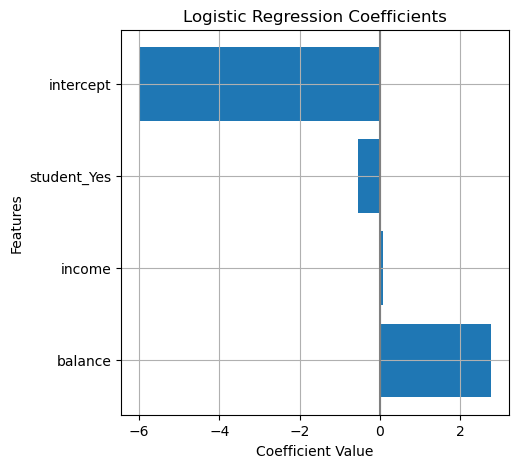

,feature,coef
2,balance,2.773691
3,income,0.070656
1,student_Yes,-0.553895
0,intercept,-5.999642


In [22]:
# Code for your answer here!
import sklearn
# Fit the model using the training data
log_pipe.fit(X_train, y_train)
# Compute accuracy on the test data (see hint)
accuracy = log_pipe.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
# Plot the coefficients using the helper function
coef_df = get_coefs(log_pipe, plot=True, figtitle="Logistic Regression Coefficients")
display(coef_df)

_Accuracy: The model achieved a test accuracy of 0.9750 (or 97.5%). While this sounds excellent, we must remember our earlier observation: the dataset has a severe class imbalance where ~96.67% of individuals did not default. A "dummy" model that simply predicts "No Default" for everyone would automatically achieve roughly 96.67% accuracy. Therefore, our model is only slightly outperforming a naive guess, showing why accuracy is a flawed metric for highly imbalanced data.\
Coefficient Interpretation: Balance (2.773691): This coefficient is large and positive. Holding other variables constant, higher credit card balances significantly increase the log-odds (and therefore the probability) of an individual defaulting. Because we applied  to this feature, this represents the change in log-odds for every one standard deviation increase in balance.StandardScaler Student_Yes (-0.553895): This coefficient is negative. This tells us that, surprisingly, being a student actually decreases the log-odds of defaulting compared to a non-student, assuming their balance and income are exactly the same. Income (0.070656): This coefficient is very close to zero. This confirms our Exploratory Data Analysis findings: an individual's income has almost no significant impact on predicting whether they will default when factored into this model._

## Evaluating Classification Models: Beyond Accuracy

Because of the imbalanced nature of the data, looking at accuracy alone is misleading. Indeed, a naive classifier that predicts no one defaults would achieve a high accuracy of 96.7%.  

A binary classifier can make two types of errors:

- Incorrectly assigning an individual __who defaults__ to the __no default__ category (FN)
- Incorrectly assigning an individual who __does not default__ to the __default__ category (FP)

To better understand the FN vs FP tradeoff, we can compute the confusion matrix. Recall from our notes, the quantities reported in the confusion matrix are:


$$\text{TP} = \sum_{n=1}^N \mathbb{I}(y_n=1)\mathbb{I}(\widehat{y}_n=1),\quad \text{FP} = \sum_{n=1}^N \mathbb{I}(y_n=0)\mathbb{I}(\widehat{y}_n=1)$$
$$\text{FN} = \sum_{n=1}^N \mathbb{I}(y_n=1)\mathbb{I}(\widehat{y}_n=0), \quad \text{TN} = \sum_{n=1}^N \mathbb{I}(y_n=0)\mathbb{I}(\widehat{y}_n=0)$$


where $y_n$ is the true class and $\widehat{y}_n$ is the estimated class. 

### 🚩 Exercise 4 (CORE)

1. Use [ConfusionMatrixDisplay.from_estimator](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_estimator) to compute and visualize the confusion matrix. 
2. Comment on the importance of FNs compared to FPs to the credit card company.

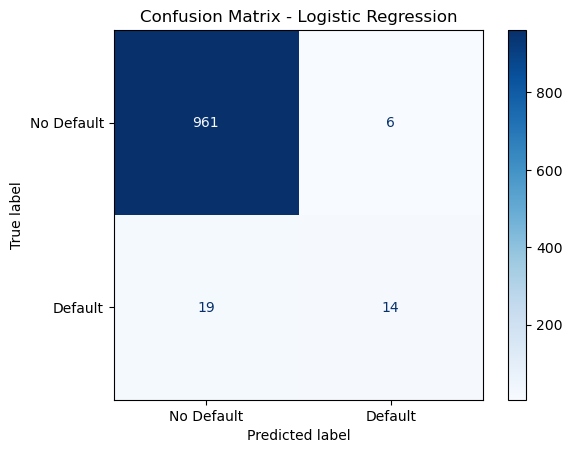

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

# Code for your answer here!
disp = ConfusionMatrixDisplay.from_estimator(
    log_pipe, 
    X_test, 
    y_test, 
    cmap=plt.cm.Blues, 
    display_labels=["No Default", "Default"]
)

plt.title("Confusion Matrix - Logistic Regression")
plt.show()

_Business Impact for the Credit Card Company: For a credit card company, a False Negative is significantly more dangerous and costly than a False Positive. If the company makes a False Positive error, they might deny a credit card to a perfectly reliable customer. The cost here is simply the opportunity cost—the missed chance to earn interest and fees from that specific person. If the company makes a False Negative error, they extend credit to someone who eventually fails to pay it back. The cost here is the loss of the actual loaned capital (the unpaid balance), which is a direct and often massive financial hit. Conclusion: Looking at our matrix, the model actually missed more defaults (19 FNs) than it correctly identified (14 True Positives). Because the financial loss of a default (FN) far outweighs the opportunity cost of a lost customer (FP), the credit card company should prioritize adjusting this model to minimize False Negatives, even if it means slightly increasing False Positives._

Recall from our notes, the different evaluation measures can be defined from the confusion matrix, such as:

$$
\text{Accuracy} = \frac{\text{TP + TN}}{\text{TP + TN + FP + FN}}
$$

$$
\text{FPR} = \frac{\text{FP}}{\text{FP}+ \text{TN}}, \hspace{0.5cm} \text{Recall (TPR)} = \frac{\text{TP}}{\text{TP}+ \text{FN}} \hspace{0.5cm}
\text{Precision} = \frac{\text{TP}}{\text{TP}+ \text{FP}}
$$


$$
\text{F1-Score} = 2\left(\frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}\right) = \frac{\text{2TP}}{\text{2TP + FP + FN}}
$$

To compute these quantites and more, functions are available in `sklearn.metrics`, including:

1. [Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) (True Positive Rate)
3. [Precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)
4. [F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
5. [AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

For a detailed list, see https://scikit-learn.org/1.5/modules/model_evaluation.html#classification-metrics.

### 🚩 Exercise 5 (CORE)

Compute the accuracy, recall, precision, and F1-score on the test data for the fitted model (using the functions in `sklearn.metrics`) and comment on the model's performance.

**Hint** you first need to use `.predict()` to predict the class labels.

In [24]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

# Code for your answer here!
y_pred = log_pipe.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

Accuracy:  0.9750
Precision: 0.7000
Recall:    0.4242
F1-Score:  0.5283


_Accuracy: The model achieved an accuracy of 97.5%. As discussed in the notes, because of the highly imbalanced nature of the data, looking at accuracy alone is misleading.\
Precision: Precision measures the proportion of true positive predictions out of all positive predictions made by the model. A precision of 70% means that when this model predicts an individual will default, it is correct 70% of the time.\
Recall: Recall measures the proportion of actual defaults that were correctly identified by the model. A recall of ~42.4% indicates that the model is only catching roughly 42% of the defaults, completely missing the other ~58%. Since False Negatives represent the largest financial risk to the credit card company, this low recall score is a major weakness of the current model.\
F1-Score: The F1-Score calculates the harmonic mean of precision and recall. Because the recall is so low, it pulls the overall F1-Score down to ~52.8%. This provides a much more realistic view of the model's actual predictive performance on the minority class than the 97.5% accuracy score._

### 🚩 Exercise 6 (EXTRA)

Based on the confusion matrix computed below. Use the equations above to derive:

1. False Positive Rate 
2. Recall
3. Precision
4. F1-score

without using any additional built-in function from any module. If computed correctly, the numbers should match the previous exercise.

In [25]:
from sklearn.metrics import confusion_matrix

# Predict class labels
y_test_pred = log_pipe.predict(X_test)

# Compute confusion matrix
confmat = confusion_matrix(y_true = y_test, y_pred=y_test_pred)
confmat

array([[961,   6],
       [ 19,  14]])

In [26]:
# Code for your answer here!
TN = confmat[0, 0]
FP = confmat[0, 1]
FN = confmat[1, 0]
TP = confmat[1, 1]

fpr = FP / (FP + TN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)
f1 = 2 * (precision * recall) / (precision + recall) 

print(f"False Positive Rate: {fpr:.4f}")
print(f"Recall:              {recall:.4f}")
print(f"Precision:           {precision:.4f}")
print(f"F1-Score:            {f1:.4f}")

False Positive Rate: 0.0062
Recall:              0.4242
Precision:           0.7000
F1-Score:            0.5283


### 🚩 Exercise 7 (CORE)

The handy function `RocCurveDisplay.from_estimator` is also available in `sklearn` for plotting  ROC curve for the fitted model. Use this function to plot the ROC curve and compute the AUC using `sklearn.metrics.roc_auc_score` on the test data. Comment on the model's performance based on these quantities.

**Hint** you will need to use `predict_proba()` to compute the class probabilities for each data point, in order to compute the AUC.

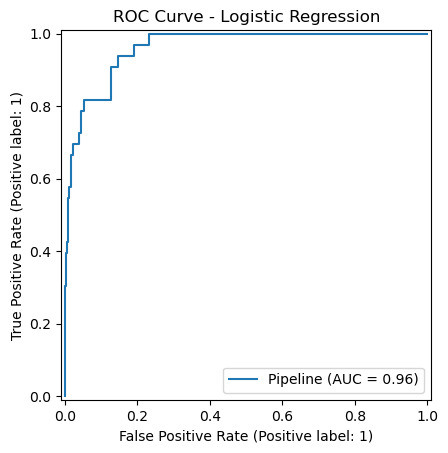

AUC Score: 0.9618


In [27]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score

# Code for your answer here!
RocCurveDisplay.from_estimator(log_pipe, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()

y_test_proba = log_pipe.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_test_proba)
print(f"AUC Score: {auc:.4f}")

_ROC Curve Interpretation: The ROC curve plots the True Positive Rate against the False Positive Rate across all possible classification thresholds. Our plotted curve bows tightly toward the top-left corner. This is the ideal shape, demonstrating that the model is highly capable of maximizing True Positives while keeping False Positives relatively low across various threshold settings.\
AUC Score: The Area Under the Curve summarizes the ROC curve's performance into a single metric. Our model achieved an excellent AUC of ~0.96. A score this close to 1.0 means the underlying model is doing a fantastic job of separating the classes—it consistently assigns higher predicted probabilities of defaulting to actual defaulters than to non-defaulters.\
Model Performance Context: Recall from Exercise 5 that our model had a poor recall score. That poor recall was strictly an artifact of using the default 0.5 probability threshold to make predictions. This high AUC score proves that the model itself is actually very strong; if the credit card company simply lowers the decision threshold from 0.5 to something lower, they could significantly improve their Recall without causing an unacceptable spike in False Positives._

### 🚩 Exercise 8 (CORE)

Now, use the function `PrecisionRecallDisplay.from_estimator` to plot the Precision-Recall curve for the fitted model on the test data. Comment on the model's performance based on this figure.

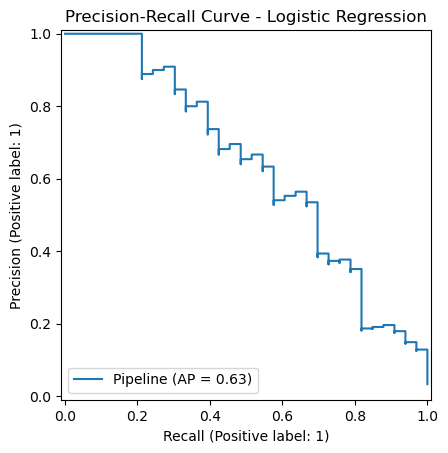

In [28]:
from sklearn.metrics import PrecisionRecallDisplay

# Code for your answer here!
PrecisionRecallDisplay.from_estimator(log_pipe, X_test, y_test)
plt.title("Precision-Recall Curve - Logistic Regression")
plt.show()

_PR Curve vs. ROC Curve: Unlike the ROC curve from Exercise 7, which looked near-perfect with an AUC of ~0.96, this Precision-Recall curve provides a much more grounded assessment. Because it ignores the massive number of True Negatives (people who easily pay their bills) and focuses strictly on the minority class, it reveals the model's actual struggle to identify defaults accurately.\
The Visual Trade-off: The step-like downward slope illustrates the harsh trade-off between Precision and Recall. The curve shows that if the credit card company wants to achieve a high recall—for example, catching 80% of all defaults—the precision plunges to roughly 0.2 to 0.4. This means that out of everyone the model flags as a potential defaulter at that threshold, only 20% to 40% will actually default, resulting in a large number of reliable customers being denied credit (False Positives).\
Average Precision: The AP score of 0.63 summarizes the area under this curve. While it demonstrates that the model has more predictive power than random guessing, it clearly highlights the limitations of standard Logistic Regression on this highly imbalanced data. It confirms that the 97.5% accuracy score we saw earlier was dangerously misleading._

# Regularization <a id='SKV'></a>

Regularization can be useful in logistic regression to deal with high-dimensional data and for variable selection. As previous stated `LogisiticRegression` offers four options through the 'penalty' parameter:
- `penalty=None` corresponds to no regularization,
- `penalty=l2` is the default and corresponds to l2 regularization (ridge),
- `penalty=l1` corresponds to l1 regularization (lasso), and
- `penalty=elasticnet` corresponds to a combination of l1 and l2 regularizaiton.

For the three regularization methods, the parameter `C` represents the inverse strength of the penalty parameter. Additionaly, when using `elasticnet`, `l1_ratio` is an additional penalty parameter, controlling the balance between l1 and l2 regularization.

Note: the choice of the algorithm (aka solver) depends on the penalty chosen (see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for more details.)

As we saw last week, it is important to tune the penalty parameter `C` (and `l1_ratio` if using elastic net) when including regularization. Before we start searching over hyperparameters, its worth noting that some of the folds may not have the same distribution of the classes. This is particulary important for imbalanced data and means the we could get a validation score that may be a poor estimate of performance (for example we may have a fold with very few positive classes or more than usual, which can cause large differences on imbalanced data). To address this,  when doing our grid search, we will use a `StratifiedKFold` to ensure the distribution of classes in our folds reflects the distribution in the larger data.

Run the code below to investigate the difference in class distributions across folds when using `Kfold` vs `StratifiedKfold`.


In [ ]:
# Consider 5 folds
KF = KFold(n_splits=5)
SKF = StratifiedKFold(n_splits=5)

fold_names = ["KFold", "StratifiedKFold"]
for i, K in enumerate([KF, SKF]):
    # Initialize an empty DataFrame to store counts for the current fold type
    fold_nos = pd.DataFrame()
    for j, (train_i, test_i) in enumerate(K.split(X_train, y_train)):
        # Compute value counts for the current fold and ensure it's a DataFrame with appropriate columns
        fold_no = pd.DataFrame(pd.Series(y_train[test_i]).value_counts()).T
        fold_no.index = ["Fold " + str(j)]  # Rename the index to reflect the fold number
        # Concatenate with the fold_nos DataFrame
        fold_nos = pd.concat([fold_nos, fold_no], axis=0)
    
    fold_nos.fillna(0, inplace=True)  # Fill missing values with 0 if any class was not present in a fold
    print(f"{fold_names[i]} counts per fold:\n", fold_nos)

Next, let's perform a grid search to tune the regularization parameter with l2 regularization. Notice that we have listed multiple metrics to save with the option `scoring=`. However, setting `refit=` will select the best model and refit according to the  specfied metric.

In [ ]:
# This code snippet sets up and executes a grid search for tuning the penalty parameter
# of a logistic regression model with l2 regularization using cross-validation. 

# Pipeline 
log_pipe_l2 = make_pipeline(
    ColumnTransformer(
        [("cat", OneHotEncoder(drop=["No"]), ['student']),
         ("num", StandardScaler(), ['balance','income'])],
         verbose_feature_names_out=False
    ),
    LogisticRegression(random_state=42, penalty='l2')
)

# Uncomment this line to find how the penalty parameter is called in the pipeline
#log_pipe.get_params()

# Possible C values: 
C_list = np.linspace(0.01, 10, num=151)


# Grid search CV:
log_rs = GridSearchCV(log_pipe_l2, 
                      param_grid={'logisticregression__C': C_list},
                      scoring = ["accuracy", "f1","recall","precision"], #Evaluation metrics to compute on validation sets
                      cv = StratifiedKFold(n_splits=5, shuffle=True),
                      refit = "accuracy", # Refits the best model on the entire dataset using the accuracy metric 
                      return_train_score = True)

# Tune the model with grid search:
log_rs.fit(X_train, y_train)

### 🚩 Exercise 9 (CORE)

a. Run the following code to plot the mean accuracy averaged across the validation folds (in black). Comment on the suggested value of `C`.

b. Choose a metric other than accuracy (i.e. f1, recall, or precision) and redraw the figure to plot the mean across the validation folds. Does your suggested value of `C` change?

In [ ]:
# Extract only mean and split scores
cv_accuracy = pd.DataFrame(
    data = log_rs.cv_results_
).filter(
    # Extract the split#_test_accuracy and mean_test_accuracy columns
    regex = '(split[0-4]+|mean)_test_accuracy'
).assign(
    # Add the alphas as a column
    C = C_list
)

# Reshape the data frame for plotting
d = cv_accuracy.melt(
    id_vars=('C','mean_test_accuracy'),
    var_name='fold',
    value_name='Accuracy'
)

# Plot the validation scores across folds
plt.figure(figsize=(7,5))
sns.lineplot(x='C', y='Accuracy', color='black', errorbar=None, data = d)  # Plot the mean score in black.
sns.lineplot(x='C', y='Accuracy', hue='fold', data = d) # Plot the curves for each fold in different colors
plt.show()

_Part a: Type your answer here_

In [ ]:
# Part b: Code for your answer here



_Part b: Type your answer here_ 

### 🚩 Exercise 10 (EXTRA)

a. Rebuild your model with `l1` regularization and perform a grid search to tune the penalty parameter. Which metric have you chosen for refitting the model and why?

b. Plot the coefficients using the helper function. Which variables are included? How does the performance compare to the model with no regularization?

In [ ]:
# Code for your answer here

_Type your answer here_

# Dealing with Imbalanced Data <a id='Imbal'></a>

We have already seen that when dealing with imbalanced data, we need to 
1. Considering a suitable performance metric both for testing and validation.
2. Use a suitable splitting strategy (stratified splitting) both in creating our test and validation sets.

But the majority class can still overwelm the minority class when fitting the model. To investigate, let's use the function  [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), which reports summary of the precision, recall, F1 score for each class. Note that:
- the recall of the positive class is also known as *sensitivity*; recall of the negative class is *specificity*.
- it also includes the *macro average* (averaging the unweighted mean per label) as well as the weighted average (averaging the support-weighted mean per label). 

In [ ]:
# Compute and print the classification report for the model with no penatly
from sklearn.metrics import classification_report

print(classification_report(y_test, 
                            log_pipe.predict(X_test), 
                            target_names = ['No Default','Default']))

Notice, how the metrics are much higher for the majority class (individuals who have not deafulted). In this case, we may want to alter the training algorithm or data by:

1. Weighting the classes during training.
2. Resampling the data.

`LogisticRegression` offers the option to include class weights, and for example `class_weight="balanced"` will weight the classes by: $ \frac{N}{2 N_c}$, where  $N_c$ for $c = 0, 1$ counts the number of observations in each class. Notice how the metrics in classification report change when including this option in the code below. 

In [ ]:
log_pipe_balan = make_pipeline(
    ColumnTransformer(
        [("cat", OneHotEncoder(drop=["No"]), ['student']),
         ("num", StandardScaler(), ['balance','income'])],
         verbose_feature_names_out=False
    ),
    LogisticRegression(random_state=42, penalty=None, class_weight='balanced')
).fit(X_train, y_train)

print(classification_report(y_test, 
                            log_pipe_balan.predict(X_test), 
                            target_names = ['No Default','Default']))

In the following, the focus is on suitable **resampling** to change the distribution of the classes in our training data.

## Resampling

To alter the distribution of the classes in our training data, there are two main approaches:

- Under-sampling the majority class
- Over-sampling the minority class

We will be using Imbalanced-learn (imported as `imblearn`), an open source, MIT-licensed library relying on scikit-learn that provides tools for dealing with classification with imbalanced classes (see [here](https://imbalanced-learn.org/stable/introduction.html) for an introduction). Let's start by installing the `imblearn` package if necessary.

In [ ]:
# Install the imblearn if necessary 
#!pip install imblearn

In the previous notebooks, we learned about _transformers_, which allow us to __alter the features__ and not the number of observations in our data (i.e. the columns of $\mathbf{X}$). Instead, _resamplers_ provide a preprocessing step in our `Pipeline` to __alter the number of observations__ and not the features (i.e. the rows of $\mathbf{X}$ and $\mathbf{y}$).

__Resamplers__

Resamplers are classes that follow the scikit-learn API and have a sampling functionality through the `.resample()` method. Like all other scikit-learn methods, they have a `.fit()` method which is only applied during pipeline training. This means if we want to create our own resampler from scratch that is compatible with scikit-learn, we just have to make a class that has three methods; `.fit()`,  `.resample()`, and `.fit_resample()`; with the latter just chaining the other two together.

Therefore to resample a dataset, each sampler implements:

```
obj.fit(data, targets)
data_resampled, targets_resampled = obj.resample(data, targets)
```

or simply...

```
data_resampled, targets_resampled = obj.fit_resample(data, targets)
```

**Remember to include your sampler within your model pipeline to prevent data leakage!**


### Under-Sampling

Under-sampling involves removing observations from the majority class to prevent its signal from dominating during training. We will focus on the simplest strategy:

- [`RandomUnderSampler`](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html), which randomly removes observations from the majority class.

For an overview of other under-samplers, see: https://imbalanced-learn.org/stable/under_sampling.html

In [ ]:
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.under_sampling import RandomUnderSampler

# Pipeline with under sampling
log_pipe_us = ImPipeline([
    ("fe",ColumnTransformer(
        [("cat", OneHotEncoder(drop=["No"]), ['student']),
         ("num", StandardScaler(), ['balance','income'])],
         verbose_feature_names_out=False
    )),
   ("sampler", RandomUnderSampler(random_state=42)),
   ("model", LogisticRegression(random_state=42, penalty=None))])

# Fit model     
log_pipe_us.fit(X_train, y_train)

### 🚩 Exercise 11 (CORE)

Compute and print the classification report and visualize the confusion matrix for the model above with undersampling. How have the results changed?

In [ ]:
# Code for your answer here

_Type your answer here_ 

## Oversampling

Over-sampling involves generating additional observations from the minority class. We will focus on the simplest strategy:

- [`RandomOverSampler`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html), which randomly samples with replacement observations from the minority class.

For an overview of other over-samplers, see: https://imbalanced-learn.org/stable/over_sampling.html

### 🚩 Exercise 12 (CORE)

a. Create a new pipeline for a logisitic regression model with oversampling (by copying and editting the pipeline above).

b. How do the performance metrics compare with under-sampling?

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Code for your answer here

_Type your answer here_

---
# Multi-class Logistic Regression <a id='mclog'></a>

Finally, to gain some experience with multi-class logistic regression, let's now look at the `iris` data set, which we have seen already in lectures.  

This is an example where the response has **3 classes** corresponding to the three types of iris species and $D=4$ features (petal length, petal width, sepal length, sepal width).

Let's start by loading the data and doing some basic EDA.

In [ ]:
# First load the data 
from sklearn.datasets import load_iris

# Loading data
iris = pd.DataFrame(sns.load_dataset('iris'))

# Print information about the data set
print(iris.info())
print(iris.describe())
print(iris['species'].value_counts())

# Pairplot
sns.pairplot(data = iris, hue = 'species',corner=True)
plt.show()

From the intial EDA, we observe:
- The features have similar, but slightly different scales.
- Visually, the species appear to be fairly well separated.
- The target variable `species` is a string and we will need a label encoding
- The species types are equal distributed, and thus no methods for class imbalance are needed.

Now, let's separate the features and target, encode the target, and split into training and test sets.

In [ ]:
# Feature matrix and response vector
X, y = iris.drop(['species'], axis=1), iris['species']

# Encode target
y = LabelEncoder().fit_transform(y)

# Split into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True) 

### 🚩 Exercise 13 (CORE)

We can use the same `LogisticRegression` for the multi-class setting. In this case, it will fit the **multinomial logistic regression** model. Fit a multinomial logisitic regression model and visualize the confusion matrix.

In [ ]:
# Code for your answer here!

### 🚩 Exercise 14 (EXTRA)

In the multi-class setting, the `.coeff_` attribute is a $ C\times D $ matrix of the model coefficents. Recall that the log odds of being in class $ c $ relative to class $ c^\prime $ is:

 $$ \log \left(\frac{p(y=c \mid \mathbf{x})}{p(y=c^\prime \mid \mathbf{x})} \right) =  \log \left(\frac{\exp(\mathbf{w}_c^T\mathbf{x})}{\sum_{l=1}^C\exp(\mathbf{w}_l^T\mathbf{x})} /  \frac{\exp(\mathbf{w}_{c^\prime}^T\mathbf{x})}{\sum_{l=1}^C\exp(\mathbf{w}_l^T\mathbf{x})} \right) = \left(\mathbf{w}_{c} - \mathbf{w}_{c^\prime} \right)^T\mathbf{x}$$

 For each unique pair of classes, create a barplot to visualize the coefficients of one class relative to another, i.e. $\mathbf{w}_{c} - \mathbf{w}_{c^\prime}$. Which features are most important for distinguishing between classes? Interpret how a unit change in the features affects the odds of being in one class relative to another.

In [ ]:
# Code for your answer here



_Type your answer here_

# Competing the Worksheet

At this point you have hopefully been able to complete all the CORE exercises and attempted the EXTRA ones. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Before generating the PDF, please **change 'Student 1' and 'Student 2' at the top of the notebook to include your name(s)**.

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF. Once generated, please submit this PDF on Learn page by 16:00 PM on the Friday of the week the workshop was given. 

In [ ]:
!jupyter nbconvert --to pdf mlp_week06.ipynb 